## Notes for estimatic yield curves
$$cd = p$$
$$d = c^{-1} p$$
$$d_i = e^{-r_i t_i} \rightarrow r_i = -\frac{ln(d_i)} { t_i} $$

In [1]:
# %load_ext autoreload
# %autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la
from scipy.interpolate import interp1d
plt.rcParams['figure.figsize'] = [1.25*6.4, 1.25*4.8]

In [2]:
## Data fra et eksempel i "Options, Futures And Other Derivative", J. C. Hull [1]

# table 4.3 [1]
data = {
    "bond_principal": [100.0, 100.0, 100.0, 100.0, 100.0],
    "time_to_maturity": [0.25, 0.50, 1.00, 1.50, 2.00],
    "annual_coupon": [0, 0, 0, 8, 12],
    "bond_price": [97.6, 94.9, 90.0, 96.0, 101.6],
    #"bond_price": [97.5, 94.9, 90.0, 96.0, 101.6],
}

# table 4.4 [1] (expected discount yield points)
result = {
    "time_to_maturity": [0.25, 0.50, 1.00, 1.50, 2.00],
    "zero_rate": [10.127, 10.469, 10.536, 10.681, 10.808],
}

# cashflow matrix generated from table 4.3
cashflow = [
    [100, 0, 0, 0, 0],
    [0, 100, 0, 0, 0],
    [0, 0, 100, 0, 0],
    [0, 4, 4, 104, 0],
    [0, 6, 6, 6, 106],
]

# load data
def load_data():
    """returns casflows, prices, and times of payments"""
    cf = np.asarray(cashflow, dtype=float)
    p = np.asarray(data["bond_price"])
    t = np.asarray(data["time_to_maturity"])
    return cf, p, t


In [3]:
def d2r(d, t):
    """discount->rate"""
    return -np.log(d) / t


def estimate_discount_curve(c, p):
    """Bootstrap fra cashflow matrix *c*, prices *p* and times *t*"""
    return la.solve(c, p)


In [4]:
cf, p, t = load_data()

discount_curve = estimate_discount_curve(cf, p)
curve = d2r(discount_curve, t)

curve_rounded = np.around(curve * 100, 3)
print(curve_rounded)  # passer med eksemplet i hull på side 107

[ 9.717 10.469 10.536 10.681 10.808]


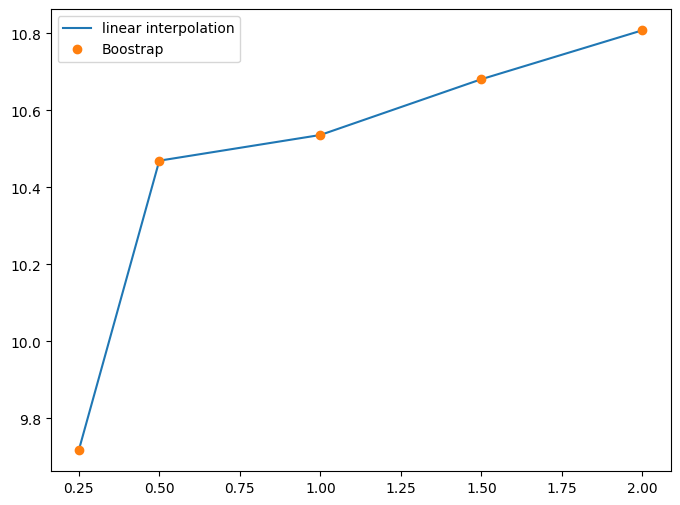

In [5]:
linear_interpol = interp1d(t, curve * 100)

xs = np.linspace(t.min(), t.max(), 100)
ys = linear_interpol(xs)

plt.plot(xs, ys, label="linear interpolation")
plt.plot(t, curve * 100, "o", label="Boostrap")
plt.legend()


In [6]:
# Implementation of: "Exact Smooth Term-Strucure Estimation", Damir Filipovic and Sander Willems 2018


def add_g0_constraint(cf, p, t):
    """adds g(0)=1 constraint"""
    n, m = cf.shape
    cf2, p2, t2 = np.zeros((n + 1, m + 1)), np.zeros(n + 1), np.zeros(m + 1)
    cf2[1:, 1:], p2[1:], t2[1:] = cf.copy(), p.copy(), t.copy()
    cf2[0, 0], p2[0] = 1, 1
    return cf2, p2, t2


def phi(tau, x):
    """ Unique vector <- H that evaluates the dicount curve at *tau* through the
        Riesz representation theorem: Phi_tau(g) = <phi_tau, g>_H = g(tau)
    """
    y = min(tau, x)
    return 1 - y**3 / 6 + x * tau * (2 + y) / 2


def a_matrix(ts):
    n = len(ts)
    a = np.empty((n, n))
    for i in range(n):
        for j in range(n):
            a[i, j] = phi(ts[i], ts[j])
    return a


def z_vector(a, c, p):
    return c.T @ la.solve(c @ a @ c.T, p)


def make_g_star(c, p, t):
    ct, pt, tt = add_g0_constraint(c, p, t)
    z = z_vector(a_matrix(tt), ct, pt)

    def g_star(x: float) -> float:
        return np.dot(z, [phi(tau=xi, x=x) for xi in tt])

    return g_star


In [7]:
cf, p, t = load_data()

g_star = make_g_star(cf, p, t)

# esitmer kurven på en række tidspunkter
xs2 = np.linspace(0.25, 2.0, 100)
gs = [g_star(x) for x in xs2]
curve2 = d2r(gs, xs2)


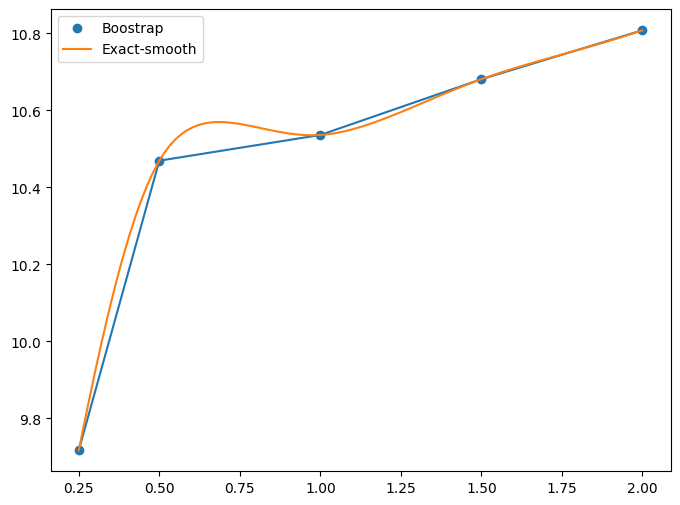

In [8]:

# plot kurverne
plt.plot(xs, ys)  # interpolated bootstrap
plt.plot(t, curve * 100, 'o', label='Boostrap', c='C0')
plt.plot(xs2, curve2 * 100, label='Exact-smooth')
plt.legend()